In [1]:
%load_ext autoreload
%autoreload 2

HACK

In [2]:
from batteryprobe.data import create_data_loader
from batteryprobe.loops import evaluate

In [3]:
import pandas as pd
import seaborn as sns
from torch.nn.utils.rnn import pad_packed_sequence
import matplotlib.pyplot as plt

In [4]:
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [6]:
df = pd.read_csv("all.csv")
df = df.iloc[::9]

In [54]:
params = {
    "max_gap_between_sessions": 400,
    "min_num_points_per_session": 10,
    "min_session_duration": 600,
    "label_lower_bound": 0.6,
    "label_upper_bound": 0.3, 
    "progressive_bound": True,
    "label_bounds": [0.8, 0.6, 0.4],
    "lstm_layers": 1,
    "train_split": 0.7,
    "features": [
#         'charge_full',
#         'current_now',
#         'n_running_threads',
#         'load_average_5',
#         'load_average_1',
#         'load_average_15',
#         'voltage_now',
#         'cpu_temp',
#         'fans_rpm',
#         'charge_now',
        'capacity',
    ],
    "context": [
        'epoch_sin',
        'epoch_cos',
        'battery_status_Charging',
        'battery_status_Discharging',
        'os_linux',
        'os_macos',
        'charge_full_design',
    ],
    "batch_size": 12,
    "repeat": 5,
    "debug": False,
    "n_data_workers": 4,
    "prefetch": 2,
    "t2v_k": 5
}

In [56]:
train_dataloaders, val_dataloaders = create_data_loader(df, params)

INFO:root:20875 data points
DEBUG:root:13370f11455f4f36a0680b9725189375 - 3507 points
DEBUG:root:Extracted 102 sessions
DEBUG:root:5fbc9f85604740eb85dbf9dbd495de67 - 631 points
DEBUG:root:Extracted 22 sessions
DEBUG:root:0a236299cff2433fbd19467990418ba4 - 4875 points
DEBUG:root:Extracted 109 sessions
DEBUG:root:73b12e7317274a1ea491b1a8b21d6eb0 - 128 points
DEBUG:root:Extracted 3 sessions
DEBUG:root:6c328af026994ab5ae14d1eb27d92e2b - 9726 points
DEBUG:root:Extracted 263 sessions
DEBUG:root:e18acda9486c41fc8d19777cd114ac39 - 2007 points
DEBUG:root:Extracted 60 sessions
INFO:root:Extracted 559 sessions
INFO:root:Progressive training bound: Loading multiple train sessions with different bounds


In [58]:
print(len(train_dataloaders), len(val_dataloaders))
print(len(train_dataloaders[0]), len(val_dataloaders[0]))
print(len(train_dataloaders[1]), len(val_dataloaders[1]))
print(len(train_dataloaders[2]), len(val_dataloaders[2]))

3 3
55 14
55 14
55 14


In [59]:
for train in train_dataloaders:    
    for (inputs, time, context), label in train:
        unpacked_inputs, lengths = pad_packed_sequence(inputs, batch_first=True, padding_value=-999)
        print(unpacked_inputs.shape)
        print(lengths)
        unpacked_context, lengths = pad_packed_sequence(context, batch_first=True, padding_value=-999)
        print(unpacked_context.shape)
        print(lengths)
        unpacked_time, lengths = pad_packed_sequence(time, batch_first=True, padding_value=-999)
        print(unpacked_time.shape)
        print(lengths)
        break

torch.Size([12, 94, 8])
tensor([31, 25, 17, 16, 20, 23, 39, 14, 18, 16, 24, 94])
torch.Size([12, 24, 7])
tensor([ 8,  7,  5,  5,  6,  6, 10,  4,  5,  5,  7, 24])
torch.Size([12, 118])
tensor([ 39,  32,  22,  21,  26,  29,  49,  18,  23,  21,  31, 118])
torch.Size([12, 40, 8])
tensor([15, 40, 13, 37, 20, 17, 34, 31, 40, 23, 33, 20])
torch.Size([12, 28, 7])
tensor([11, 27, 10, 25, 14, 12, 24, 22, 28, 16, 22, 14])
torch.Size([12, 68])
tensor([26, 67, 23, 62, 34, 29, 58, 53, 68, 39, 55, 34])
torch.Size([12, 39, 8])
tensor([15, 39, 23, 36,  6, 16, 12,  5, 11, 13, 10, 18])
torch.Size([12, 60, 7])
tensor([24, 60, 35, 54,  9, 24, 19,  9, 18, 21, 17, 28])
torch.Size([12, 99])
tensor([39, 99, 58, 90, 15, 40, 31, 14, 29, 34, 27, 46])


In [60]:
target_col = params["features"].index("capacity")

In [61]:
import matplotlib.pyplot as plt
import numpy as np

In [62]:
from random import randint
randint(0, 10)
import matplotlib.dates as mdate
from batteryprobe.utils import plot_sample

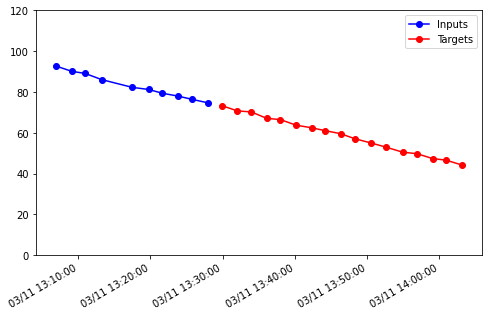

In [72]:
plot_sample(train_dataloaders[2], target_col=target_col, n=1)

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from batteryprobe.utils import pad_and_pack, masked_l1
from batteryprobe.models import Baseline

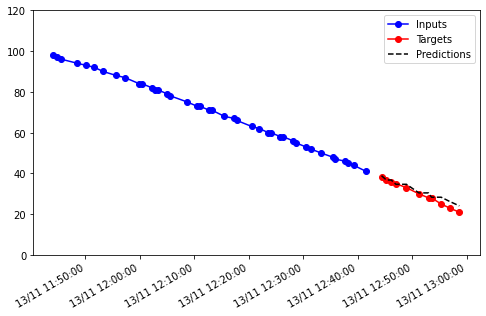

In [74]:
baseline = Baseline(target_col)
plot_sample(val_dataloaders[0], target_col, n=1, model=baseline)

In [75]:
score = evaluate(baseline, val_dataloaders[0], target_col=target_col)

Loss 2.05942: 100%|██████████| 14/14 [00:00<00:00, 29.50it/s]


In [76]:
from torch.nn import init
import math
from torch.nn.utils.rnn import pad_sequence

In [77]:
class Time2Vec(nn.Module):
    def __init__(self, k, periodic_activation_function=torch.sin):
        super().__init__()
        self.k = k
        self.periodic_activation_fn = periodic_activation_function
        omega = torch.Tensor(k)
        self.omega = nn.Parameter(omega)
        phi = torch.Tensor(k)
        self.phi = nn.Parameter(phi)
        
        # Initialization phase and frequency
        bound = 1
        init.uniform_(self.omega, -bound, bound)
        init.uniform_(self.phi, -bound, bound)

    def forward(self, t):
        return self.periodic_activation_fn(t @ self.omega[None, :] + self.phi)

In [78]:
t2v = Time2Vec(params["t2v_k"])
inputs = torch.ones((5, 10, 1))
outputs = t2v(inputs)
outputs.shape

torch.Size([5, 10, 5])

In [ ]:
element 1 
1 2 3 4 5 6 7 8 9
inputs  1 2 3 4 5 6
targets 7 8 9
time 1 2 3 4 5 6 7 8 9

element 2
1 2 3 4
inputs  1 2 3
targets 4
time    1 2 3 4

inputs
1 2 3 4 5 6
1 2 3 0 0 0

targets
7 8 9
4 0 0

time 
el1 1 2 3 4 5 6 7 8 9
el2 1 2 3 4 0 0 0 0 0


In [50]:
 # pylint: disable=C0103
class AutoRegressive(nn.Module):
    """AutoRegressive model.

    Attributes:
        in_size (int): Size in input of the model.
        out_size (init): Size in output of the model.
        lstm (nn.LSTM): The lstm layer.
        dense (nn.Linear): The dense layer.

    Args:
        params(dict): Parameters dict.
    """

    def __init__(self, params):
        self.params = params
        super().__init__()
        self.in_size = len(self.params["features"]) + len(self.params["context"]) + params["t2v_k"]
        self.out_size = len(self.params["features"])
        self.t2v = Time2Vec(k=params["t2v_k"])
        self.lstm = nn.LSTM(self.in_size, 64, num_layers=params["lstm_layers"], batch_first=True)
        self.dense = nn.Linear(64, self.out_size)

    # pylint: disable=W0613
    def forward(self, x, time, context):
        """Forward pass.

        Args:
            x (torch.Tensor): inputs
            time (torch.nn.utils.rnn.PackedSequence): Timestamps
            context (torch.nn.utils.rnn.PackedSequence): Context
        """
        # Embed time and add it to inputs 
        x, time_embedding = self.embed_time(x, time)

        # Pass into warmup
        x, warmup_state = self._warmup(x)

        # Unpack context for outputs prediction
        context, lengths_context = pad_packed_sequence(
            context,
            batch_first=True,
            padding_value=-999
        )
        # Loop over every element of a batch
        batch = []
        for i, element in enumerate(x):
            # State corresponding to a single element in a batch
            state = (  # (num_layers, batch, hidden_size)
                torch.unsqueeze(warmup_state[0][:, i, :], 1),
                torch.unsqueeze(warmup_state[1][:, i, :], 1),
            )

            # Add first prediction from warmup
            timestamps = [element[None, None, :]]

            # Predict values
            # pylint: disable=C0103
            for t in range(lengths_context[i] - 1):
                # The order here is important. Inputs features should be first
                in_tensor = torch.cat([element, context[i, t, :], time_embedding[i, t, :]], axis=-1)[None, None, :]
                x, state = self.lstm(in_tensor, state)
                x = self.dense(x)
                timestamps.append(x)
            batch.append(torch.cat(timestamps, 1)[0])

        # Pack and pad sequence
        return pad_and_pack(batch)

    def _warmup(self, x):
        x, state = self.lstm(x)
        x, lengths = pad_packed_sequence(x, batch_first=True, padding_value=-999)
        x = torch.stack([x[i, length - 1] for i, length in enumerate(lengths)])
        x = self.dense(x)
        return x, state

    def embed_time(self, x, time):
        """Use Time2Vec layer to compute a time embedding and add it to input features."""
        time, time_len = pad_packed_sequence(time,
            batch_first=True, padding_value=-999
        )
        time_embedding = self.t2v(torch.unsqueeze(time, -1))
        x, x_len = pad_packed_sequence(x, 
            batch_first=True, padding_value=-999
        )
        inputs_time_embedding = pad_sequence([
            time_embedding[i, :length] for i, length in enumerate(x_len)],
            batch_first=True, padding_value=-999
        )
        x = torch.cat((x, inputs_time_embedding), 2)
        x = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)

        return x, time_embedding

In [51]:
model = AutoRegressive(params)

In [52]:
for train in train_dataloaders:
    for (inputs, time, context), labels in train:
        model(inputs.float(), time.float(), context.float())
        break 

In [53]:
N_EPOCHS = 10
LEARNING_RATE = 3e-3

criterion = masked_l1
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = []
val_history = []
best_loss = 9999


for epoch in range(N_EPOCHS):
    
    ################################################################
    # Training 
    ################################################################
    running_loss = 0
    pbar = tqdm(train_dataloaders[0]) 
    for i, ((inputs, time, context), labels) in enumerate(pbar):
        optimizer.zero_grad()
        
        # Find number of out steps for each element in the batch
        out_steps = pad_packed_sequence(labels, batch_first=True, padding_value=-999)[1]
        outputs = model(inputs.float(), time.float(), context.float())
        
        # Pad packed labels and outputs
        pad_labels, _ = pad_packed_sequence(labels, batch_first=True, padding_value=-999)
        pad_outputs, _ = pad_packed_sequence(outputs, batch_first=True, padding_value=-999)

        loss = criterion(pad_outputs, pad_labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if not (i % 5):
            pbar.set_description(
                f"Epoch #{epoch+1} - Loss = {running_loss / (i+1):.5f}\t"
            )
    history.append(running_loss / (i+1))

    ################################################################
    # Validation
    ################################################################
    val_running_loss = 0
    pbar = tqdm(val_dataloaders[0])
    with torch.no_grad():
        for j, ((inputs, time, context), labels) in enumerate(pbar):
            out_steps = pad_packed_sequence(labels, batch_first=True, padding_value=-999)[1]
            
            outputs = model(inputs.float(), time.float(), context.float())
            
            # Pad packed labels and outputs
            pad_labels, _ = pad_packed_sequence(labels, batch_first=True, padding_value=-999)
            pad_outputs, _ = pad_packed_sequence(outputs, batch_first=True, padding_value=-999)

            loss = criterion(pad_outputs, pad_labels.float())
            val_running_loss += loss  # MSE per batch
            pbar.set_description(
                f"Validation loss = {val_running_loss / (j+1):.5f}\t"
            )
        # Callbacks
        # Keep best model
        #if (val_running_loss / (j+1)) < best_loss:
        #    logging.info(f"Validation loss improved from {best_loss} to {(val_running_loss / (j+1))}")
        #    best_loss = (val_running_loss / (j+1))
        #    torch.save(model.state_dict(), "model.pt")
            
    val_history.append(val_running_loss / (j+1))

Epoch #1 - Loss = 63.95952	:   7%|▋         | 11/163 [00:01<00:27,  5.62it/s]


KeyboardInterrupt: 

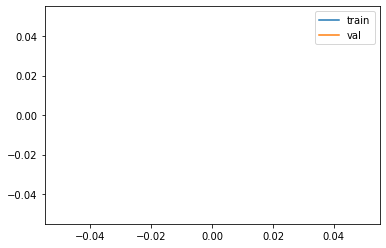

In [29]:
plt.plot(history, label="train")
plt.plot(val_history, label="val")
plt.legend()
plt.show()

In [ ]:
#model = AutoRegressive(params)
#model.load_state_dict(torch.load("model.pt"))
#model.eval()

In [ ]:
score = evaluate(model, train, target_col=target_col)

In [ ]:
plot_sample(train_dataloaders[2], target_col, n=10, model=model)

In [ ]:
criterion = masked_l1
n = 5
bad_apples = [0 for _ in range(n)]
res = [None for _ in range(n)]
pbar = tqdm(val)

with torch.no_grad():
    for i, ((inputs, time, context), labels) in enumerate(pbar):
        outputs = model(inputs.float(), time.float(), context.float())
        inputs, inputs_len = pad_packed_sequence(inputs,
            batch_first=True, padding_value=-999)
        time, time_len = pad_packed_sequence(time,
            batch_first=True, padding_value=-999)
        context, context_len = pad_packed_sequence(context,
            batch_first=True, padding_value=-999)
        labels, labels_len = pad_packed_sequence(labels,
            batch_first=True, padding_value=-999)
        outputs, outputs_len = pad_packed_sequence(outputs,
            batch_first=True, padding_value=-999)

        for j in range(inputs.shape[0]):
            loss = criterion(
                outputs[j, :, target_col],
                labels[j, :, target_col],
            )
            smallest = min(bad_apples)
            if loss > smallest:
                idx = bad_apples.index(smallest)
                bad_apples[idx] = loss
                res[idx] = (
                    (inputs[j], time[j], context[j], outputs[j],
                     inputs_len[j], labels_len[i]), 
                    labels[j]
                )
                
for (x, time, context, outputs, len_i, len_o), y in res:
    fig, ax = plt.subplots(figsize=(8, 5))
    date = mdate.epoch2num(time)

    ax.plot_date(
        date[:len_i],
        x[:len_i, target_col],
        "bo-", label="Inputs"
    )
    ax.plot_date(
        date[len_i:len_i+len_o],
        y[:len_o, target_col],
        "ro-", label="Targets"
    )
    ax.plot_date(
        date[len_i:len_i+len_o],
        outputs[:len_o, target_col],
        "k--", label="Predictions"
    )
    
    date_fmt = '%d/%m %H:%M:%S'
    date_formatter = mdate.DateFormatter(date_fmt)
    ax.xaxis.set_major_formatter(date_formatter)
    fig.autofmt_xdate()
    plt.ylim([0, 120])
    plt.legend()
    plt.show()

In [ ]:
bad_apples

In [ ]:
res